In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy import interpolate
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression

import warnings # Supress warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../task/student_data.csv', sep =',')
data

,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect,context
0,1,8,653.0,195.0,4324.0,1917829.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,50,659.0,198.0,4096.0,1917495.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,89,645.0,149.0,4054.0,1917365.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,128,752.0,213.0,4090.0,1918146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,169,652.0,232.0,4088.0,1919319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8824673,48,4225425,NaN,NaN,NaN,NaN,0.0,0.0,-10.0,0.0,NaN,NaN,NaN,NaN
8824674,48,4225455,-808.0,42.0,4038.0,3349663.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8824675,48,4225495,-792.0,-89.0,3885.0,3404833.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8824676,48,4225535,-806.0,-78.0,4130.0,3316474.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.shape
data.info()
data.isna()

In [3]:
for col in data:
  num_missing = data[data[col].isna() ==True].shape[0]
  print('Anzahl der NAN-Werte pro Spalte {}: {}'.format(col, num_missing))

Anzahl der NAN-Werte pro Spalte sessionId: 0
Anzahl der NAN-Werte pro Spalte timestamp: 0
Anzahl der NAN-Werte pro Spalte x: 338892
Anzahl der NAN-Werte pro Spalte y: 338892
Anzahl der NAN-Werte pro Spalte z: 338892
Anzahl der NAN-Werte pro Spalte ppgValue: 338892
Anzahl der NAN-Werte pro Spalte hr: 8487003
Anzahl der NAN-Werte pro Spalte hrIbi: 8487003
Anzahl der NAN-Werte pro Spalte hrStatus: 8487003
Anzahl der NAN-Werte pro Spalte ibiStatus: 8487003
Anzahl der NAN-Werte pro Spalte notification: 8824306
Anzahl der NAN-Werte pro Spalte engagement: 8824306
Anzahl der NAN-Werte pro Spalte affect: 8824438
Anzahl der NAN-Werte pro Spalte context: 8824445


In [ ]:
#filtered_df = data.dropna(how = "all", subset=['affect', 'context']) 
#filtered_df

In [3]:
cleaned_data = data.dropna(thresh=6, axis=0).drop(0).fillna(np.nan) # Thresh =4 bedeutet, dass minimal 4 Werte von den NAN-Werte verschieden sind.
cleaned_data

,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect,context
1,1,50,659.0,198.0,4096.0,1917495.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,89,645.0,149.0,4054.0,1917365.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,128,752.0,213.0,4090.0,1918146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,169,652.0,232.0,4088.0,1919319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,209,582.0,210.0,4093.0,1920154.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8824673,48,4225425,NaN,NaN,NaN,NaN,0.0,0.0,-10.0,0.0,NaN,NaN,NaN,NaN
8824674,48,4225455,-808.0,42.0,4038.0,3349663.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8824675,48,4225495,-792.0,-89.0,3885.0,3404833.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8824676,48,4225535,-806.0,-78.0,4130.0,3316474.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Die preprocessed Daten laden --> auf NaNs prüfen --> Korrelationsmatrix und Pairplots zum Datenverständnis 

In [3]:
data_cleaned = pd.read_csv('../task/preprocessed_student_data.csv', sep =',')
data_cleaned.head()

,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect,context,timestamp_seconds
0,1,265519,-0.900336,-0.818680,-0.929223,-1.357665,-1.705613,-1.157861,-10.0,1.0,NaN,NaN,RELAXED,NaN,265.519
1,1,265559,-0.974493,-0.864809,-0.873521,-1.358288,-1.705613,-1.157861,-10.0,1.0,NaN,NaN,RELAXED,NaN,265.559
2,1,265600,-0.970043,-0.956506,-0.912270,-1.358733,-1.705613,-1.157861,-10.0,1.0,NaN,NaN,RELAXED,NaN,265.600
3,1,265639,-0.955212,-0.945255,-0.940727,-1.357803,-1.705613,-1.157861,-10.0,1.0,NaN,NaN,RELAXED,NaN,265.639
4,1,265680,-0.993773,-0.925565,-1.017014,-1.356774,-1.705613,-1.157861,-10.0,1.0,NaN,NaN,RELAXED,NaN,265.680


In [3]:
for col in data_cleaned:
  num_missing = data_cleaned[data_cleaned[col].isna() ==True].shape[0]
  print('Anzahl der NAN-Werte pro Spalte {}: {}'.format(col, num_missing))

Anzahl der NAN-Werte pro Spalte sessionId: 0
Anzahl der NAN-Werte pro Spalte timestamp: 0
Anzahl der NAN-Werte pro Spalte x: 0
Anzahl der NAN-Werte pro Spalte y: 0
Anzahl der NAN-Werte pro Spalte z: 0
Anzahl der NAN-Werte pro Spalte ppgValue: 0
Anzahl der NAN-Werte pro Spalte hr: 0
Anzahl der NAN-Werte pro Spalte hrIbi: 0
Anzahl der NAN-Werte pro Spalte hrStatus: 0
Anzahl der NAN-Werte pro Spalte ibiStatus: 0
Anzahl der NAN-Werte pro Spalte notification: 2996054
Anzahl der NAN-Werte pro Spalte engagement: 2996054
Anzahl der NAN-Werte pro Spalte affect: 1053221
Anzahl der NAN-Werte pro Spalte context: 1006690
Anzahl der NAN-Werte pro Spalte timestamp_seconds: 0


In [6]:
data_cleaned = data_cleaned.dropna(subset=['affect', 'context']) 
data_cleaned

,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect,context,timestamp_seconds
207,1,273840,-0.817280,-1.243972,-1.373627,-0.836820,-1.705613,-0.80625,-10.0,1.0,NaN,NaN,RELAXED,OTHER,273.840
208,1,273879,-0.462069,-1.265349,-0.968578,-0.836019,-1.705613,-0.80625,-10.0,1.0,NaN,NaN,RELAXED,OTHER,273.879
209,1,273919,-0.502114,-1.378423,-0.978265,-0.835742,-1.705613,-0.80625,-10.0,1.0,NaN,NaN,RELAXED,OTHER,273.919
210,1,273960,-0.628180,-1.291789,-1.053947,-0.833803,-1.705613,-0.80625,-10.0,1.0,NaN,NaN,RELAXED,OTHER,273.960
211,1,274000,-0.643753,-1.511186,-1.270700,-0.822534,-1.705613,-0.80625,-10.0,1.0,NaN,NaN,RELAXED,OTHER,274.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995745,48,4208420,0.162772,1.818190,1.559938,-6.947695,-2.489220,-0.26051,-10.0,0.0,NaN,NaN,RELAXED,CONVERSATION,4208.420
2995746,48,4208460,0.144701,1.862090,1.679660,-6.949882,-2.489220,-0.26051,-10.0,0.0,NaN,NaN,RELAXED,CONVERSATION,4208.460
2995747,48,4208500,0.072416,1.893158,1.801186,-6.953875,-2.489220,-0.26051,-10.0,0.0,NaN,NaN,RELAXED,CONVERSATION,4208.500
2995748,48,4208540,0.187330,1.736469,1.853527,-6.962480,-2.489220,-0.26051,-10.0,0.0,NaN,NaN,RELAXED,CONVERSATION,4208.540


In [6]:
for col in data_cleaned:
  num_missing = data_cleaned[data_cleaned[col].isna() ==True].shape[0]
  print('Anzahl der NAN-Werte pro Spalte {}: {}'.format(col, num_missing))

Anzahl der NAN-Werte pro Spalte sessionId: 0
Anzahl der NAN-Werte pro Spalte timestamp: 0
Anzahl der NAN-Werte pro Spalte x: 0
Anzahl der NAN-Werte pro Spalte y: 0
Anzahl der NAN-Werte pro Spalte z: 0
Anzahl der NAN-Werte pro Spalte ppgValue: 0
Anzahl der NAN-Werte pro Spalte hr: 0
Anzahl der NAN-Werte pro Spalte hrIbi: 0
Anzahl der NAN-Werte pro Spalte hrStatus: 0
Anzahl der NAN-Werte pro Spalte ibiStatus: 0
Anzahl der NAN-Werte pro Spalte notification: 936143
Anzahl der NAN-Werte pro Spalte engagement: 936143
Anzahl der NAN-Werte pro Spalte affect: 0
Anzahl der NAN-Werte pro Spalte context: 0
Anzahl der NAN-Werte pro Spalte timestamp_seconds: 0


In [ ]:
data_cleaned.shape
data_cleaned.info()
data_cleaned.isna()

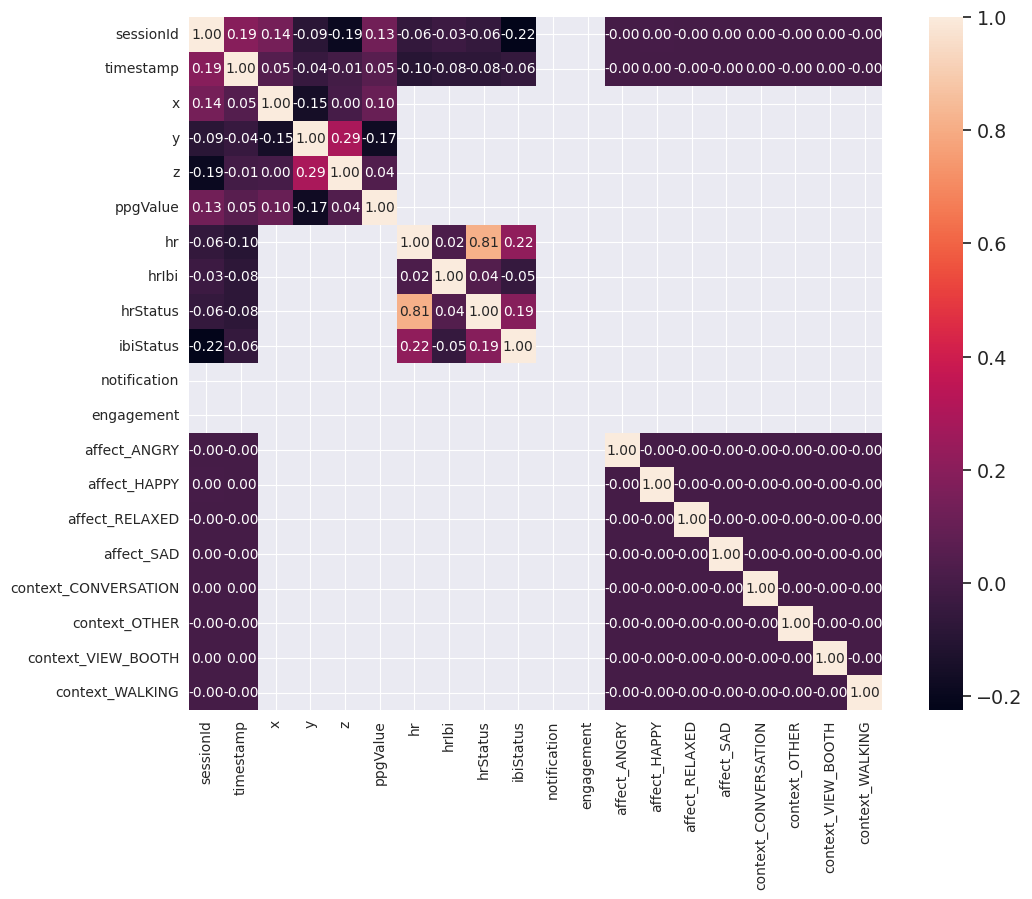

In [4]:
data_encoded = pd.get_dummies(data) #data_cleaned
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_encoded), columns=data_encoded.columns)
corrmat = data_encoded.corr()

# Erstellen Sie die Heatmap
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)
sns.heatmap(corrmat, cbar=True, square=True, annot=True,fmt='.2f', annot_kws={'size': 10});

KeyboardInterrupt: 

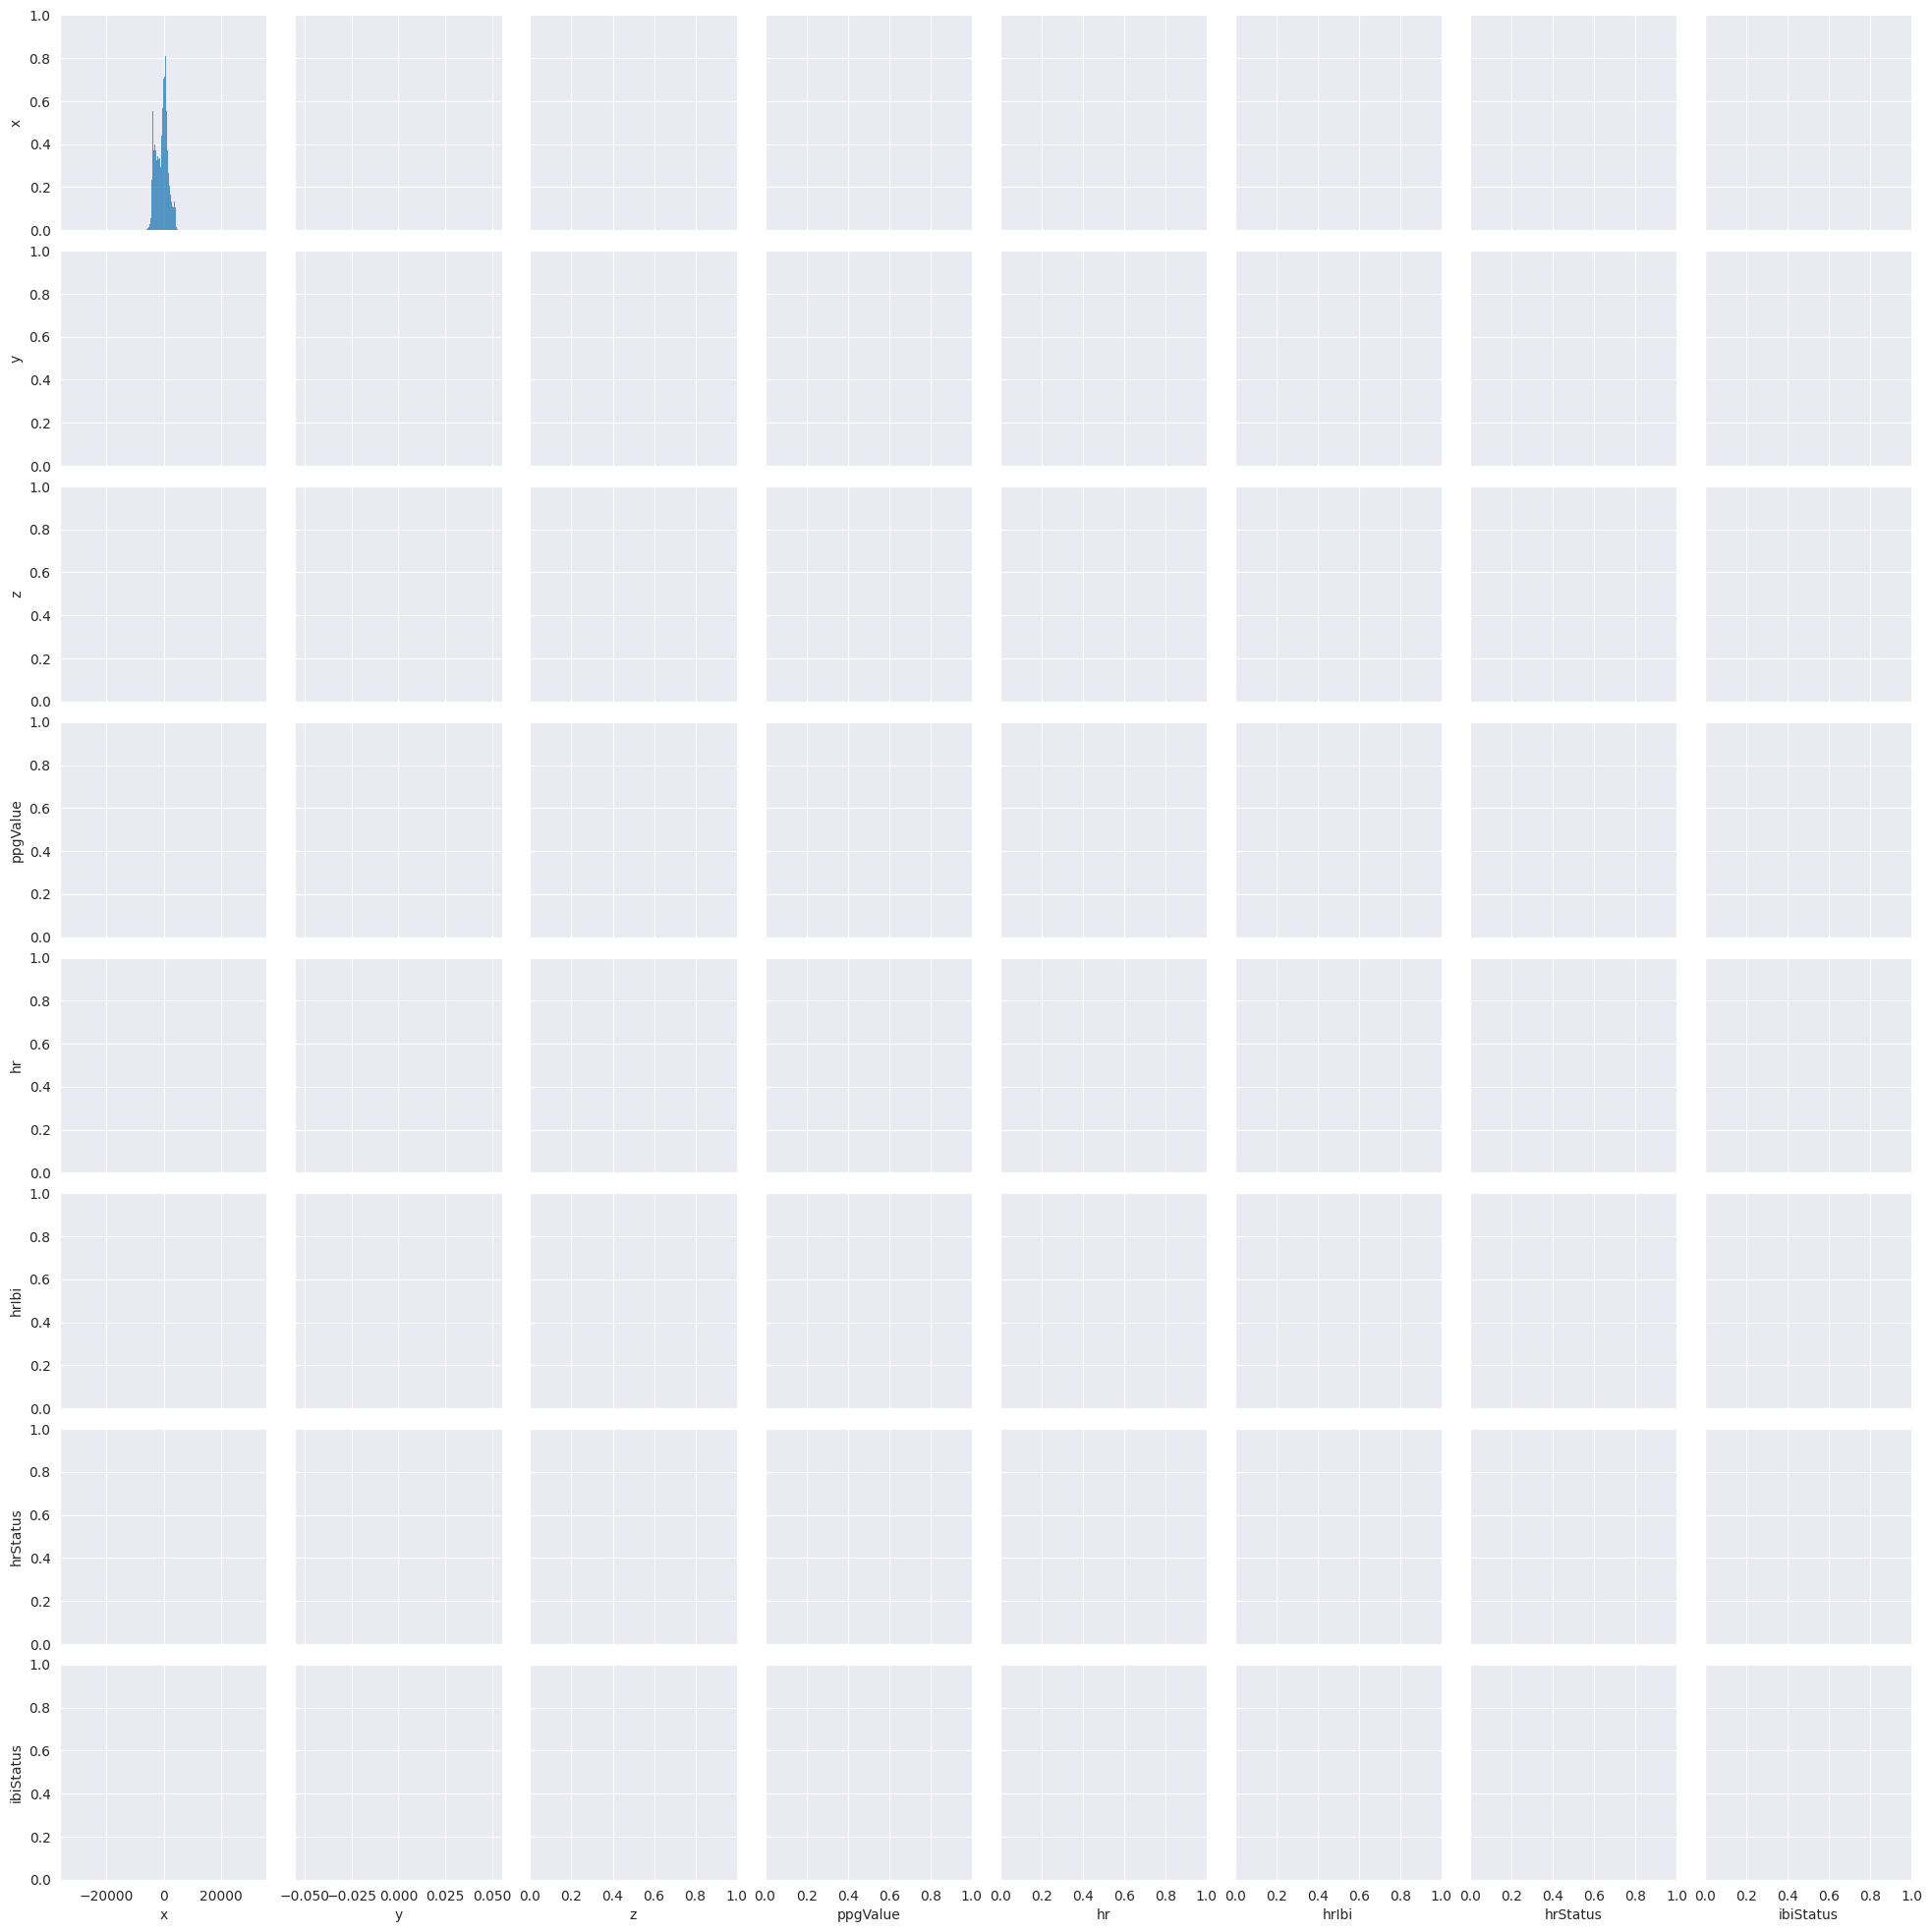

In [27]:
data_encoded = pd.get_dummies(data_cleaned)
columns = ['x', 'y', 'z', 'ppgValue', 'hr', 'hrIbi', 'hrStatus', 'ibiStatus']
sns.pairplot(data_encoded[columns])
plt.show();

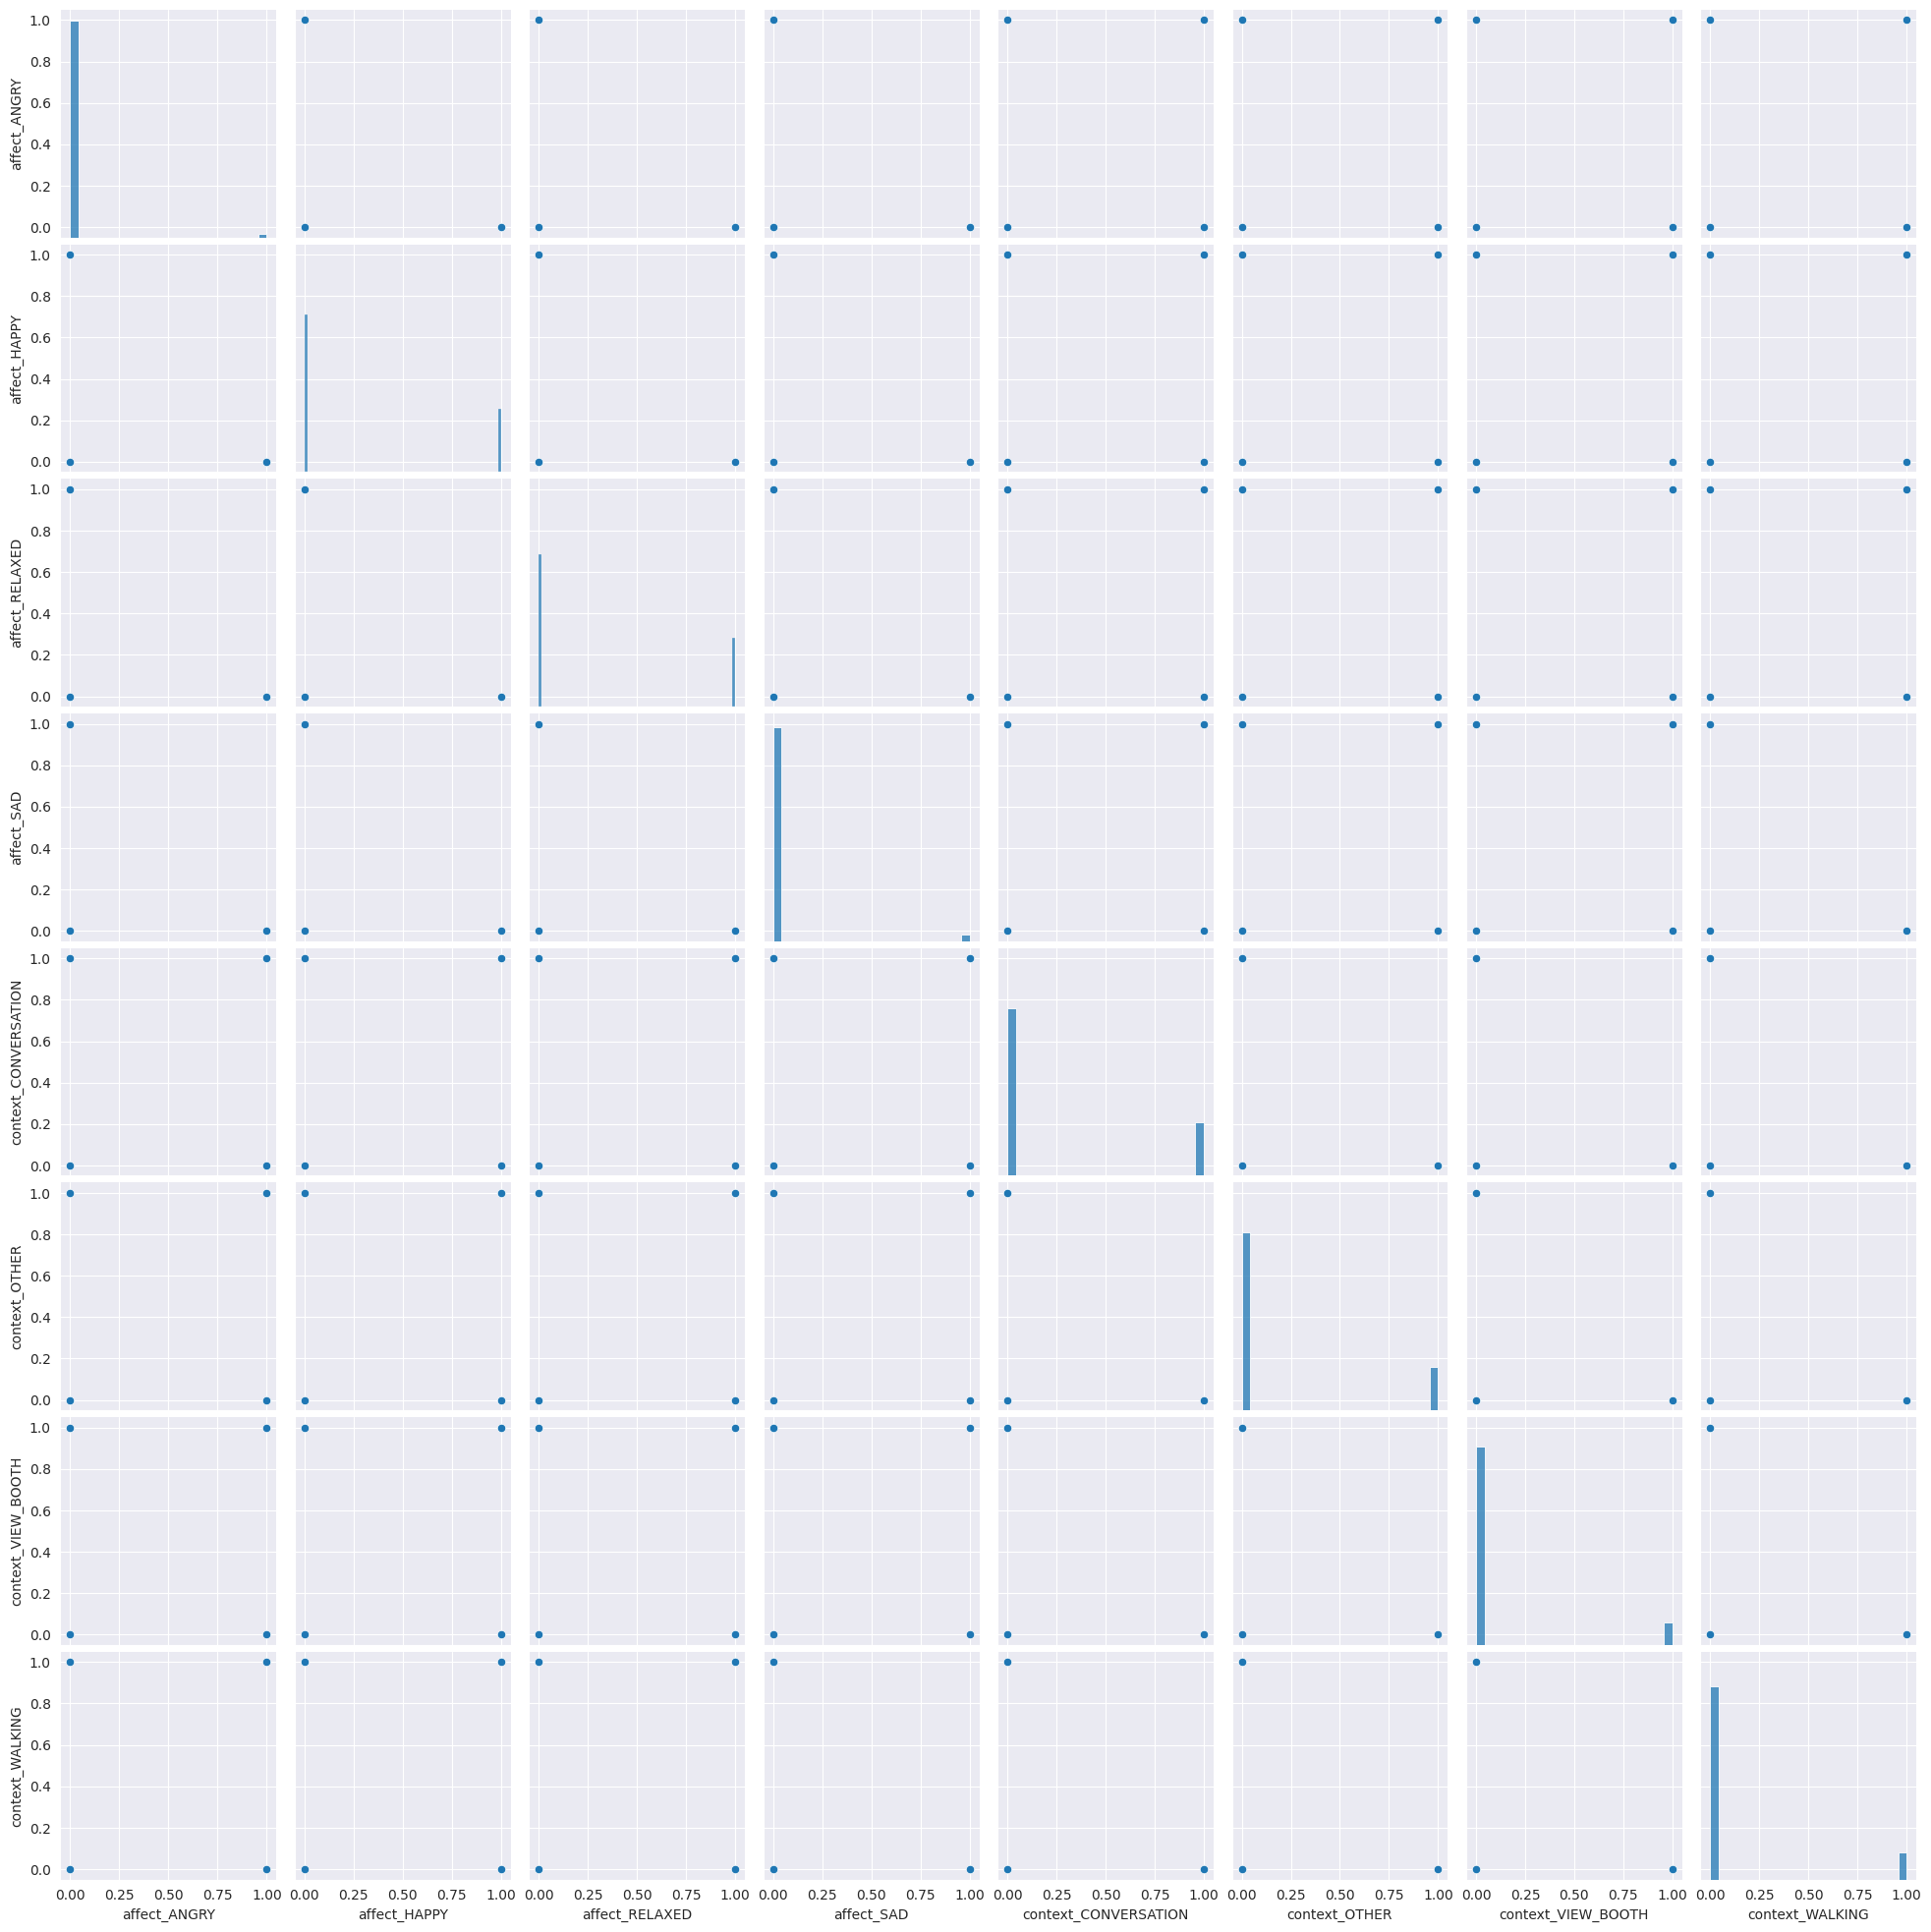

In [12]:
data_encoded = pd.get_dummies(data_cleaned)
#scaler = MinMaxScaler()
#data_normalized = pd.DataFrame(scaler.fit_transform(data_encoded), columns=data_encoded.columns)
columns_labels = ['affect_ANGRY','affect_HAPPY','affect_RELAXED','affect_SAD', 'context_CONVERSATION', 'context_OTHER', 'context_VIEW_BOOTH', 'context_WALKING']
sns.pairplot(data_encoded[columns_labels])
plt.show();

## Daten fürs Training splitten

In [7]:
X = data_cleaned.drop(['sessionId','timestamp_seconds',  'notification', 'engagement', 'context', 'timestamp', 'affect'], axis=1)
y_context = data_cleaned['context']
y_affect = data_cleaned['affect']

X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X, y_context, test_size=0.2)

le = LabelEncoder()
y_train_context_encoded = le.fit_transform(y_train_k)
y_test_context_encoded = le.transform(y_test_k)
#y_affect_encoded = le.fit_transform(y_affect)

# Kontext vorherzusagen

## AdaBoost mit Daten ohne Geschlecht und Alter

### Auswahl der "guten" Parameter für AdaBoost mit den vorliegenden Daten

In [39]:
ada = AdaBoostClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

grid_search = GridSearchCV(ada, param_grid, cv=5)

grid_search.fit(X_train_k, y_train_k)
print(grid_search.best_params_)

{'learning_rate': 1.0, 'n_estimators': 200}


In [58]:
ada1 = AdaBoostClassifier(n_estimators=200, learning_rate=1, random_state=0)
model1 = ada1.fit(X_train_k, y_train_context_encoded)
y_pred_k = model1.predict(X_test_k)


In [ ]:
print("AdaBoost Classifier Model Accuracy:", accuracy_score(y_test_context_encoded, y_pred_k))
print(classification_report(y_test_context_encoded, y_pred_k))

In [ ]:
y_test_decode = le.inverse_transform(y_test_context_encoded)
y_pred_k_decode = le.inverse_transform(y_pred_k)

print(classification_report(y_test_decode, y_pred_k_decode))

## Feature Importance: AdaBoost, wie auch andere Ensemble-Methoden, ermöglicht es, die Wichtigkeit der einzelnen Merkmale zu bestimmen. --> Balkendiagramm:

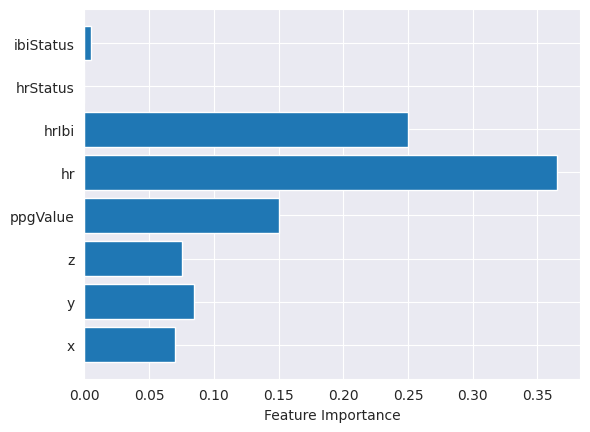

In [65]:
import matplotlib.pyplot as plt

# Hole die Feature Importance
importances = model1.feature_importances_

# Erstelle ein Balkendiagramm
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), X_train_k.columns)
plt.xlabel('Feature Importance')
plt.show()

## Konfusion-Matrix --> Korrekte vs. falsche Vorhersagen

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_decode, y_pred_k_decode)

# Erstelle eine ConfusionMatrixDisplay und zeige die Konfusionsmatrix an
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()

## AdaBoost scheint nicht viel gelernt zu haben.

## XGBoost

In [8]:
from xgboost import XGBClassifier

#svc = SVC(probability=True, kernel='linear')
#ada2 = AdaBoostClassifier(n_estimators=200, learning_rate=1, estimator=svc, random_state=0)
#model2 = ada2.fit(X_train_k, y_train_context_encoded)
#y_pred_k = model2.predict(X_test_k)
#y_test_decode2 = le.inverse_transform(y_test_context_encoded)
#y_pred_k_decode2 = le.inverse_transform(y_pred_k)
#print(classification_report(y_test_decode2, y_pred_k_decode2))

xgbc = XGBClassifier(max_depth=13,n_estimators=300,learning_rate=0.5)

xgbc.fit(X_train_k, y_train_context_encoded)
y_pred_k = xgbc.predict(X_test_k)
y_test_decode2 = le.inverse_transform(y_test_context_encoded)
y_pred_k_decode2 = le.inverse_transform(y_pred_k)
print(classification_report(y_test_decode2, y_pred_k_decode2))

              precision    recall  f1-score   support

CONVERSATION       0.99      0.99      0.99     70734
       OTHER       0.99      0.99      0.99     52550
  VIEW_BOOTH       0.99      0.98      0.99     23644
     WALKING       0.99      0.99      0.99     40301

    accuracy                           0.99    187229
   macro avg       0.99      0.99      0.99    187229
weighted avg       0.99      0.99      0.99    187229


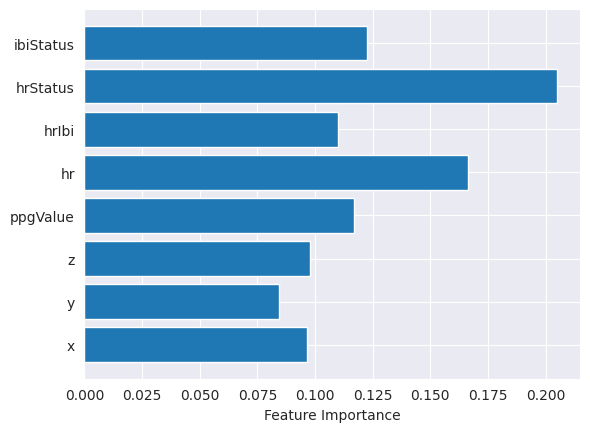

In [9]:
# Hole die Feature Importance
importances2 = xgbc.feature_importances_

# Erstelle ein Balkendiagramm
plt.barh(range(len(importances2)), importances2)
plt.yticks(range(len(importances2)), X_train_k.columns)
plt.xlabel('Feature Importance')
plt.show()

## XGBoost betrachtet mehr Parameter beim Training und trifft bessere Entscheidung.

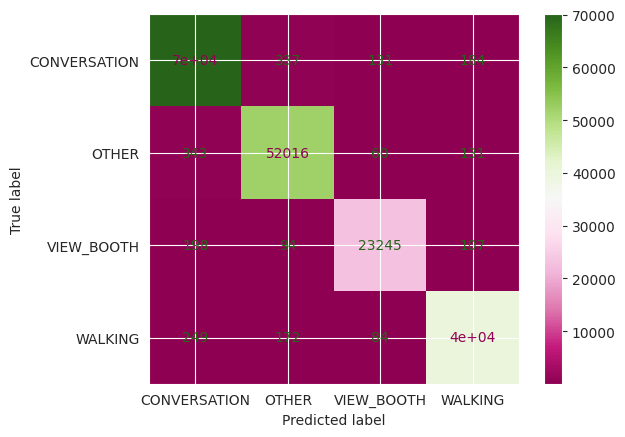

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_decode2, y_pred_k_decode2)

# Erstelle eine ConfusionMatrixDisplay und zeige die Konfusionsmatrix an
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='PiYG')
plt.savefig('Confusions_matrix_XGBoost.png')

# Experiment für dne Kontext und Emotionen mit Daten aus *preprocessed_student_data* und *student_info(gender + age)*

In [27]:
#TODO 1. Geschlecht und Alter heranziehen, damit trainieren
#TODO 2. Vorhersage-Pipeline bilden und mit dem besseren Modell die erste Abgabe vorbereiten. 

In [20]:
df1 = pd.read_csv('../task/preprocessed_student_data.csv', sep =',')
df2 = pd.read_csv('../task/session_info.csv', sep =',')

merged_df = pd.merge(df1, df2[['id', 'gender', 'age']], left_on='sessionId', right_on='id', how='left')
merged_df = merged_df.drop(columns='id')

In [3]:
#merged_df.to_csv('merged_preprocessed_data_with_info.csv', index=False)

In [21]:
merged_df = merged_df.dropna(subset=['affect', 'context']) 
merged_df

,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect,context,timestamp_seconds,gender,age
207,1,273840,-0.817280,-1.243972,-1.373627,-0.836820,-1.705613,-0.80625,-10.0,1.0,NaN,NaN,RELAXED,OTHER,273.840,female,18-25
208,1,273879,-0.462069,-1.265349,-0.968578,-0.836019,-1.705613,-0.80625,-10.0,1.0,NaN,NaN,RELAXED,OTHER,273.879,female,18-25
209,1,273919,-0.502114,-1.378423,-0.978265,-0.835742,-1.705613,-0.80625,-10.0,1.0,NaN,NaN,RELAXED,OTHER,273.919,female,18-25
210,1,273960,-0.628180,-1.291789,-1.053947,-0.833803,-1.705613,-0.80625,-10.0,1.0,NaN,NaN,RELAXED,OTHER,273.960,female,18-25
211,1,274000,-0.643753,-1.511186,-1.270700,-0.822534,-1.705613,-0.80625,-10.0,1.0,NaN,NaN,RELAXED,OTHER,274.000,female,18-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995745,48,4208420,0.162772,1.818190,1.559938,-6.947695,-2.489220,-0.26051,-10.0,0.0,NaN,NaN,RELAXED,CONVERSATION,4208.420,female,18-25
2995746,48,4208460,0.144701,1.862090,1.679660,-6.949882,-2.489220,-0.26051,-10.0,0.0,NaN,NaN,RELAXED,CONVERSATION,4208.460,female,18-25
2995747,48,4208500,0.072416,1.893158,1.801186,-6.953875,-2.489220,-0.26051,-10.0,0.0,NaN,NaN,RELAXED,CONVERSATION,4208.500,female,18-25
2995748,48,4208540,0.187330,1.736469,1.853527,-6.962480,-2.489220,-0.26051,-10.0,0.0,NaN,NaN,RELAXED,CONVERSATION,4208.540,female,18-25


In [22]:
for col in merged_df:
  num_missing = merged_df[merged_df[col].isna() ==True].shape[0]
  print('Anzahl der NAN-Werte pro Spalte {}: {}'.format(col, num_missing))

Anzahl der NAN-Werte pro Spalte sessionId: 0
Anzahl der NAN-Werte pro Spalte timestamp: 0
Anzahl der NAN-Werte pro Spalte x: 0
Anzahl der NAN-Werte pro Spalte y: 0
Anzahl der NAN-Werte pro Spalte z: 0
Anzahl der NAN-Werte pro Spalte ppgValue: 0
Anzahl der NAN-Werte pro Spalte hr: 0
Anzahl der NAN-Werte pro Spalte hrIbi: 0
Anzahl der NAN-Werte pro Spalte hrStatus: 0
Anzahl der NAN-Werte pro Spalte ibiStatus: 0
Anzahl der NAN-Werte pro Spalte notification: 936143
Anzahl der NAN-Werte pro Spalte engagement: 936143
Anzahl der NAN-Werte pro Spalte affect: 0
Anzahl der NAN-Werte pro Spalte context: 0
Anzahl der NAN-Werte pro Spalte timestamp_seconds: 0
Anzahl der NAN-Werte pro Spalte gender: 0
Anzahl der NAN-Werte pro Spalte age: 0


In [23]:
le_gender = LabelEncoder()
le_age = LabelEncoder()

merged_df['gender'] = le_gender.fit_transform(merged_df['gender'])
merged_df['age'] = le_age.fit_transform(merged_df['age'])

In [24]:
merged_df

,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect,context,timestamp_seconds,gender,age
207,1,273840,-0.817280,-1.243972,-1.373627,-0.836820,-1.705613,-0.80625,-10.0,1.0,NaN,NaN,RELAXED,OTHER,273.840,0,0
208,1,273879,-0.462069,-1.265349,-0.968578,-0.836019,-1.705613,-0.80625,-10.0,1.0,NaN,NaN,RELAXED,OTHER,273.879,0,0
209,1,273919,-0.502114,-1.378423,-0.978265,-0.835742,-1.705613,-0.80625,-10.0,1.0,NaN,NaN,RELAXED,OTHER,273.919,0,0
210,1,273960,-0.628180,-1.291789,-1.053947,-0.833803,-1.705613,-0.80625,-10.0,1.0,NaN,NaN,RELAXED,OTHER,273.960,0,0
211,1,274000,-0.643753,-1.511186,-1.270700,-0.822534,-1.705613,-0.80625,-10.0,1.0,NaN,NaN,RELAXED,OTHER,274.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995745,48,4208420,0.162772,1.818190,1.559938,-6.947695,-2.489220,-0.26051,-10.0,0.0,NaN,NaN,RELAXED,CONVERSATION,4208.420,0,0
2995746,48,4208460,0.144701,1.862090,1.679660,-6.949882,-2.489220,-0.26051,-10.0,0.0,NaN,NaN,RELAXED,CONVERSATION,4208.460,0,0
2995747,48,4208500,0.072416,1.893158,1.801186,-6.953875,-2.489220,-0.26051,-10.0,0.0,NaN,NaN,RELAXED,CONVERSATION,4208.500,0,0
2995748,48,4208540,0.187330,1.736469,1.853527,-6.962480,-2.489220,-0.26051,-10.0,0.0,NaN,NaN,RELAXED,CONVERSATION,4208.540,0,0


In [25]:
# Kontrolle, dass die Werte richtig konvertiert wurden
unique_gender_values = merged_df['gender'].unique()
print(f"Die eindeutigen Werte in der Spalte 'gender' sind: {unique_gender_values}")

unique_age_values = merged_df['age'].unique()
print(f"Die eindeutigen Werte in der Spalte 'age' sind: {unique_age_values}")

Die eindeutigen Werte in der Spalte 'gender' sind: [0 1]
Die eindeutigen Werte in der Spalte 'age' sind: [0 1 2]


In [26]:
#merged_df.to_csv('merged_preprocessed_data_with_info_numericSamples.csv', index=False)

In [7]:
X = merged_df.drop(['sessionId','timestamp_seconds',  'notification', 'engagement', 'context', 'timestamp', 'affect'], axis=1)
y_context = merged_df['context']
y_affect = merged_df['affect']

X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X, y_context, test_size=0.2)

le = LabelEncoder()
y_train_context_encoded = le.fit_transform(y_train_k)
y_test_context_encoded = le.transform(y_test_k)
#y_affect_encoded = le.fit_transform(y_affect)

In [14]:
print(list(le.classes_))

['CONVERSATION', 'OTHER', 'VIEW_BOOTH', 'WALKING']


In [8]:
y_train_context_encoded

array([0, 3, 0, ..., 2, 1, 1])

In [9]:
y_train_k

724036     CONVERSATION
118466          WALKING
85513      CONVERSATION
1620566           OTHER
1225876           OTHER
               ...     
704792       VIEW_BOOTH
267660          WALKING
818119       VIEW_BOOTH
1504803           OTHER
2446166           OTHER
Name: context, Length: 748914, dtype: object

## Vorhersage des Kontextes

In [9]:
xgbc_k = XGBClassifier(max_depth=13,n_estimators=300,learning_rate=0.5)

xgbc_k.fit(X_train_k, y_train_context_encoded)
y_pred_k = xgbc_k.predict(X_test_k)
y_test_decode2 = le.inverse_transform(y_test_context_encoded)
y_pred_k_decode2 = le.inverse_transform(y_pred_k)
print(classification_report(y_test_decode2, y_pred_k_decode2))

              precision    recall  f1-score   support

CONVERSATION       0.99      0.99      0.99     70811
       OTHER       0.99      0.99      0.99     52974
  VIEW_BOOTH       0.99      0.98      0.99     23690
     WALKING       0.99      0.99      0.99     39754

    accuracy                           0.99    187229
   macro avg       0.99      0.99      0.99    187229
weighted avg       0.99      0.99      0.99    187229


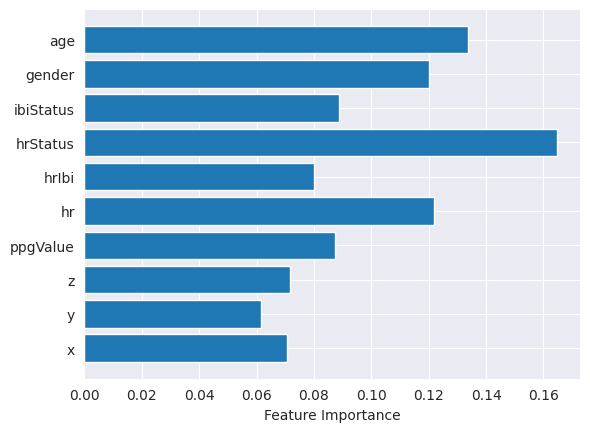

In [10]:
# Hole die Feature Importance
importances_k = xgbc_k.feature_importances_

# Erstelle ein Balkendiagramm
plt.barh(range(len(importances_k)), importances_k)
plt.yticks(range(len(importances_k)), X_train_k.columns)
plt.xlabel('Feature Importance')
plt.show()

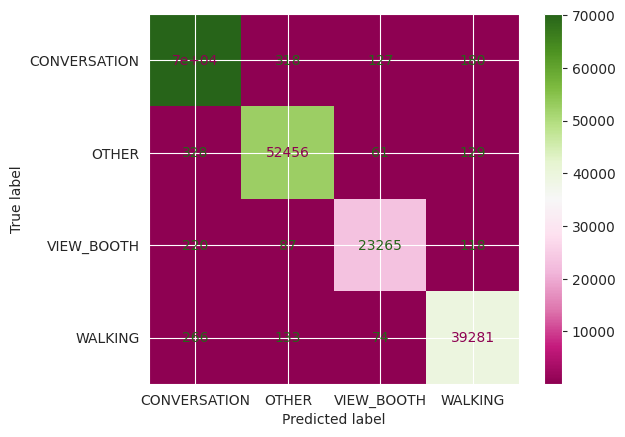

In [11]:
cm = confusion_matrix(y_test_decode2, y_pred_k_decode2)

# Erstelle eine ConfusionMatrixDisplay und zeige die Konfusionsmatrix an
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='PiYG')

In [13]:
xgbc_k.save_model("model_kontext.json")

## Laden des Modells

In [18]:
xgbc_k = XGBClassifier()
xgbc_k.load_model("model_kontext.json")

## Vorhersage der Emotionen

In [10]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y_affect, test_size=0.2)

le_a = LabelEncoder()
y_train_affect_encoded = le_a.fit_transform(y_train_a)
y_test_affect_encoded = le_a.transform(y_test_a)

In [15]:
print(list(le_a.classes_))

['ANGRY', 'HAPPY', 'RELAXED', 'SAD']


In [12]:
y_train_affect_encoded

array([2, 2, 1, ..., 2, 1, 2])

In [13]:
y_train_a

2954654    RELAXED
297861     RELAXED
1566362      HAPPY
1078704      HAPPY
1296974    RELAXED
            ...   
2226217      HAPPY
2500223    RELAXED
2620303    RELAXED
1258930      HAPPY
241759     RELAXED
Name: affect, Length: 748914, dtype: object

In [11]:
xgbc_a = XGBClassifier(max_depth=13,n_estimators=300,learning_rate=0.5)

xgbc_a.fit(X_train_a, y_train_affect_encoded)
y_pred_a = xgbc_a.predict(X_test_a)
y_test_decode_affect = le.inverse_transform(y_test_affect_encoded)
y_pred_k_decode_affect = le.inverse_transform(y_pred_a)
print(classification_report(y_test_decode_affect, y_pred_k_decode_affect))

              precision    recall  f1-score   support

CONVERSATION       0.99      0.98      0.99      9411
       OTHER       0.99      0.99      0.99     84801
  VIEW_BOOTH       0.99      0.99      0.99     87512
     WALKING       1.00      0.98      0.99      5505

    accuracy                           0.99    187229
   macro avg       0.99      0.99      0.99    187229
weighted avg       0.99      0.99      0.99    187229


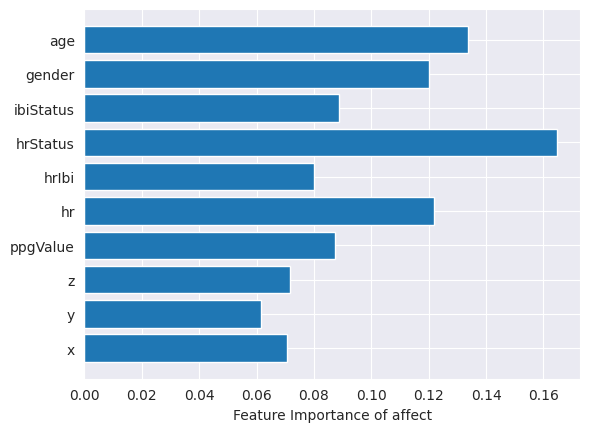

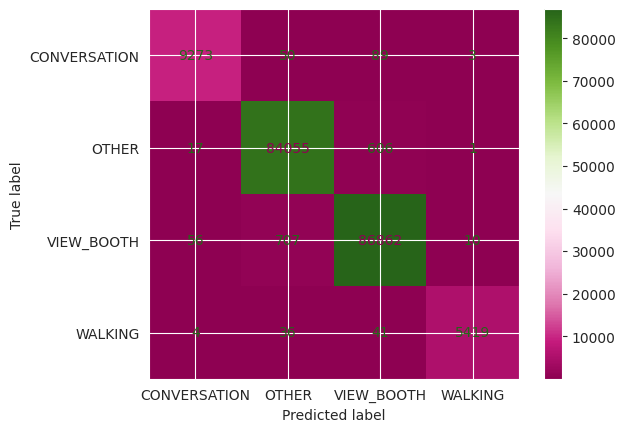

In [16]:
importances_affect = xgbc_k.feature_importances_

# Erstelle ein Balkendiagramm
plt.barh(range(len(importances_affect)), importances_affect)
plt.yticks(range(len(importances_affect)), X_train_k.columns)
plt.xlabel('Feature Importance of affect')
plt.show()

cm = confusion_matrix(y_test_decode_affect, y_pred_k_decode_affect)

# Erstelle eine ConfusionMatrixDisplay und zeige die Konfusionsmatrix an
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='PiYG')

In [17]:
xgbc_a.save_model("model_affect.json")

In [19]:
xgbc_a = XGBClassifier()
xgbc_a.load_model("model_affect.json")

# Vorbereitung für das Training für die Abgabe

In [2]:
student_skeleton = pd.read_csv('../task/student_skeleton.csv', sep=',')
student_data = pd.read_csv('../task/student_data.csv', sep=',')

# Sort the dataframes by 'sessionId' and 'timestamp'
student_skeleton.sort_values(['timestamp'], inplace=True)
student_data.sort_values(['timestamp'], inplace=True)

# Perform a merge_asof to find the closest matching 'timestamp' in 'student_data' for each row in 'student_skeleton'
merged_data = pd.merge_asof(student_skeleton, student_data, on='timestamp', by='sessionId', direction='nearest')

# After the merge_asof, the 'timestamp' column in 'merged' dataframe will have the timestamps from 'student_data'.
# We need to replace it with the timestamps from 'student_skeleton'.
merged_data['timestamp'] = student_skeleton['timestamp']

In [21]:
# Check if the timestamps are equal
timestamps_are_equal = student_skeleton['timestamp'].equals(merged_data['timestamp'])

# Print the result
if timestamps_are_equal:
    print("The timestamps of the student_skeleton and merged tables are equal.")
else:
    print("The timestamps of the student_skeleton and merged tables are not equal.")

The timestamps of the student_skeleton and merged tables are not equal.


In [8]:
merged_data.sort_values(by=['sessionId'], ignore_index=True)
merged_data

,sessionId,timestamp,affect_x,context_x,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect_y,context_y
0,23,377374,True,False,-523.0,2857.0,2740.0,2159062.0,95.0,381.0,1.0,1.0,NaN,NaN,NaN,NaN
1,15,377374,True,False,-523.0,2857.0,2740.0,2159062.0,95.0,381.0,1.0,1.0,NaN,NaN,NaN,NaN
2,8,379825,True,False,-918.0,290.0,4018.0,2097019.0,95.0,381.0,1.0,1.0,NaN,NaN,NaN,NaN
3,34,392132,True,False,628.0,481.0,4045.0,2073986.0,95.0,381.0,1.0,1.0,NaN,NaN,NaN,NaN
4,8,394062,False,True,-282.0,704.0,4154.0,2090574.0,95.0,381.0,1.0,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,51,7517280,False,True,2873.0,-596.0,3278.0,2147936.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,37,7600339,True,False,-478.0,894.0,4146.0,2296059.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190,37,7607995,False,True,-676.0,521.0,4309.0,2328349.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191,57,7634409,True,False,413.0,851.0,3999.0,2256698.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
for col in merged_data:
  num_missing = merged_data[merged_data[col].isna() ==True].shape[0]
  print('Anzahl der NAN-Werte pro Spalte {}: {}'.format(col, num_missing))

Anzahl der NAN-Werte pro Spalte sessionId: 0
Anzahl der NAN-Werte pro Spalte timestamp: 0
Anzahl der NAN-Werte pro Spalte affect_x: 0
Anzahl der NAN-Werte pro Spalte context_x: 0
Anzahl der NAN-Werte pro Spalte x: 0
Anzahl der NAN-Werte pro Spalte y: 0
Anzahl der NAN-Werte pro Spalte z: 0
Anzahl der NAN-Werte pro Spalte ppgValue: 0
Anzahl der NAN-Werte pro Spalte hr: 69
Anzahl der NAN-Werte pro Spalte hrIbi: 69
Anzahl der NAN-Werte pro Spalte hrStatus: 69
Anzahl der NAN-Werte pro Spalte ibiStatus: 69
Anzahl der NAN-Werte pro Spalte notification: 193
Anzahl der NAN-Werte pro Spalte engagement: 193
Anzahl der NAN-Werte pro Spalte affect_y: 193
Anzahl der NAN-Werte pro Spalte context_y: 193


## In Daten für die Abgabe mangelt es an einigen Werten in Spalten *hr*, *hrIbi*,*hrStatus* , *ibiStatus*. Sie müssen aufgefüllt werden. Schaue mir zuerst die Streuung an.  

In [27]:
student_data

,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect,context
0,1,8,653.0,195.0,4324.0,1917829.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,50,659.0,198.0,4096.0,1917495.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,89,645.0,149.0,4054.0,1917365.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,128,752.0,213.0,4090.0,1918146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,169,652.0,232.0,4088.0,1919319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8824673,48,4225425,NaN,NaN,NaN,NaN,0.0,0.0,-10.0,0.0,NaN,NaN,NaN,NaN
8824674,48,4225455,-808.0,42.0,4038.0,3349663.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8824675,48,4225495,-792.0,-89.0,3885.0,3404833.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8824676,48,4225535,-806.0,-78.0,4130.0,3316474.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Interpolieren hr aufgrund der vorhandenen Werte

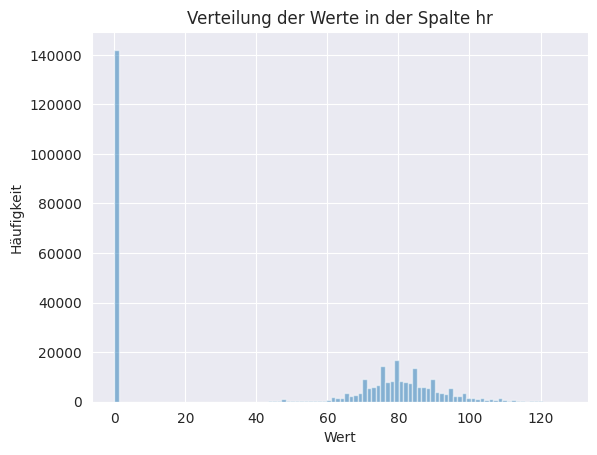

In [4]:
plt.hist(student_data['hr'].dropna(), bins=100, alpha=0.5)
plt.title('Verteilung der Werte in der Spalte hr')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.show()

In [5]:
student_data['hr'] = student_data['hr'].interpolate(method='linear')

# Überprüfen Sie das DataFrame
student_data

,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect,context
0,1,8,653.0,195.0,4324.0,1917829.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,50,659.0,198.0,4096.0,1917495.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,89,645.0,149.0,4054.0,1917365.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,128,752.0,213.0,4090.0,1918146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,169,652.0,232.0,4088.0,1919319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8824673,48,4225425,NaN,NaN,NaN,NaN,0.0,0.0,-10.0,0.0,NaN,NaN,NaN,NaN
8824674,48,4225455,-808.0,42.0,4038.0,3349663.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8824675,48,4225495,-792.0,-89.0,3885.0,3404833.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8824676,48,4225535,-806.0,-78.0,4130.0,3316474.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


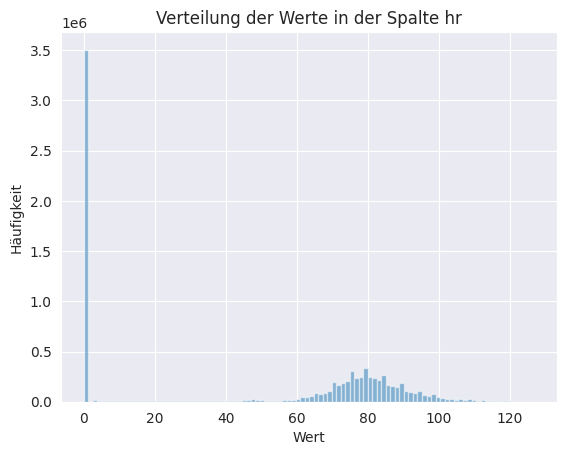

In [6]:
plt.hist(student_data['hr'].dropna(), bins=100, alpha=0.5)
plt.title('Verteilung der Werte in der Spalte hr')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.show()

## Interpolieren hrIbi aufgrund der vorhandenen Werte

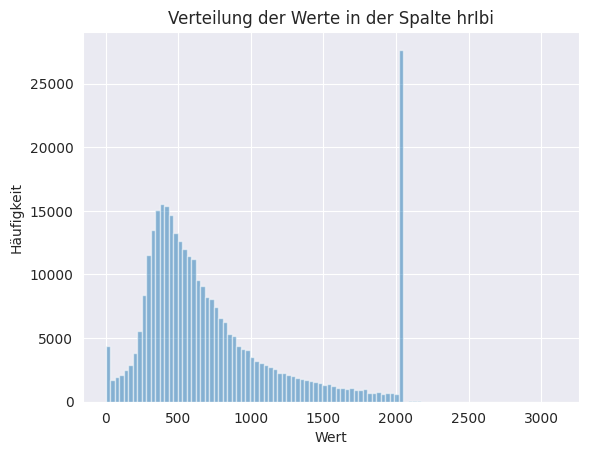

In [7]:
plt.hist(student_data['hrIbi'].dropna(), bins=100, alpha=0.5)
plt.title('Verteilung der Werte in der Spalte hrIbi')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.show()

In [8]:
student_data['hrIbi'] = student_data['hrIbi'].interpolate(method='linear')

# Überprüfen Sie das DataFrame
student_data

,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect,context
0,1,8,653.0,195.0,4324.0,1917829.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,50,659.0,198.0,4096.0,1917495.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,89,645.0,149.0,4054.0,1917365.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,128,752.0,213.0,4090.0,1918146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,169,652.0,232.0,4088.0,1919319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8824673,48,4225425,NaN,NaN,NaN,NaN,0.0,0.0,-10.0,0.0,NaN,NaN,NaN,NaN
8824674,48,4225455,-808.0,42.0,4038.0,3349663.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8824675,48,4225495,-792.0,-89.0,3885.0,3404833.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8824676,48,4225535,-806.0,-78.0,4130.0,3316474.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


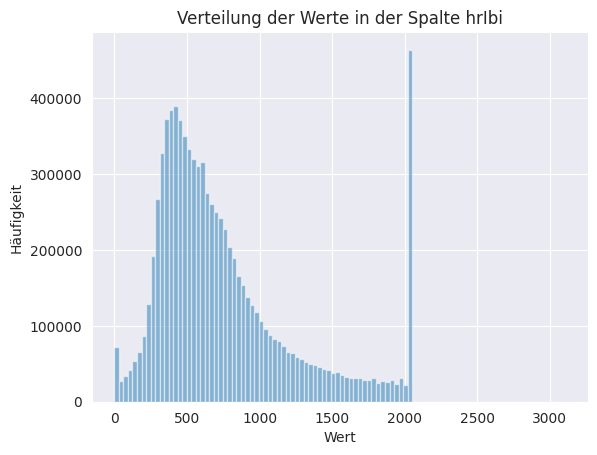

In [9]:
plt.hist(student_data['hrIbi'].dropna(), bins=100, alpha=0.5)
plt.title('Verteilung der Werte in der Spalte hrIbi')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.show()

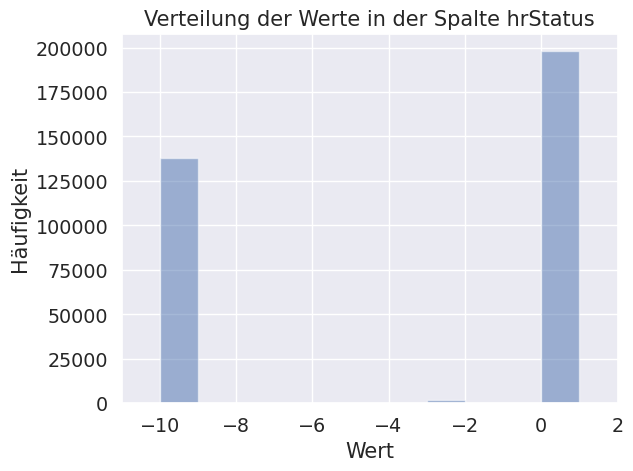

In [21]:
plt.hist(student_data['hrStatus'].dropna(), bins=1000, alpha=0.5)
plt.title('Verteilung der Werte in der Spalte hrStatus')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.xlim(-11, 2)
#plt.xticks(np.arange(-1, 1, step=0.1)) 
plt.show()

In [15]:
hrStatus = student_data['hrStatus'].value_counts() 
hrStatus

hrStatus
 1.0      195585
-10.0     137627
 0.0        2321
-3.0        2108
-1.0          12
-11.0         11
-99.0          7
-999.0         4
Name: count, dtype: int64

## Am anfang und am Ende kann man nicht interpolieren, also füllen wir die fehlenden Zellen mit Mittelwerten 

In [11]:
# Füllen Sie fehlende Werte am Anfang oder am Ende der Datenreihe mit dem Durchschnittswert
student_data['hr'] = student_data['hr'].fillna(student_data['hr'].mean())
student_data['hrIbi'] = student_data['hrIbi'].fillna(student_data['hrIbi'].mean())

for col in student_data:
  num_missing = student_data[student_data[col].isna() ==True].shape[0]
  print('Anzahl der NAN-Werte pro Spalte {}: {}'.format(col, num_missing))

Anzahl der NAN-Werte pro Spalte sessionId: 0
Anzahl der NAN-Werte pro Spalte timestamp: 0
Anzahl der NAN-Werte pro Spalte x: 338892
Anzahl der NAN-Werte pro Spalte y: 338892
Anzahl der NAN-Werte pro Spalte z: 338892
Anzahl der NAN-Werte pro Spalte ppgValue: 338892
Anzahl der NAN-Werte pro Spalte hr: 0
Anzahl der NAN-Werte pro Spalte hrIbi: 0
Anzahl der NAN-Werte pro Spalte hrStatus: 8487003
Anzahl der NAN-Werte pro Spalte ibiStatus: 8487003
Anzahl der NAN-Werte pro Spalte notification: 8824306
Anzahl der NAN-Werte pro Spalte engagement: 8824306
Anzahl der NAN-Werte pro Spalte affect: 8824438
Anzahl der NAN-Werte pro Spalte context: 8824445


## Aus der Korrelationsmatrix geht hervor, dass hr mit hrStatus stark positiv linear korreliert sind (etwa zu 80%) --> Also setze ch lineare Regression, um die Werte von hrStatus aufgrund hr aufzufüllen.

In [12]:
from sklearn.linear_model import LinearRegression

# ein DataFrame ohne fehlende Werte erstellen
df_complete = student_data.dropna(subset=['hr', 'hrStatus'])

# Trainieren
model = LinearRegression()
model.fit(df_complete[['hr']], df_complete['hrStatus'])

# Vorhersage der fehlenden Werte
student_data.loc[student_data['hrStatus'].isna(), 'hrStatus'] = model.predict(student_data[student_data['hrStatus'].isna()][['hr']])

In [13]:
for col in student_data:
  num_missing = student_data[student_data[col].isna() ==True].shape[0]
  print('Anzahl der NAN-Werte pro Spalte {}: {}'.format(col, num_missing))

Anzahl der NAN-Werte pro Spalte sessionId: 0
Anzahl der NAN-Werte pro Spalte timestamp: 0
Anzahl der NAN-Werte pro Spalte x: 338892
Anzahl der NAN-Werte pro Spalte y: 338892
Anzahl der NAN-Werte pro Spalte z: 338892
Anzahl der NAN-Werte pro Spalte ppgValue: 338892
Anzahl der NAN-Werte pro Spalte hr: 0
Anzahl der NAN-Werte pro Spalte hrIbi: 0
Anzahl der NAN-Werte pro Spalte hrStatus: 0
Anzahl der NAN-Werte pro Spalte ibiStatus: 8487003
Anzahl der NAN-Werte pro Spalte notification: 8824306
Anzahl der NAN-Werte pro Spalte engagement: 8824306
Anzahl der NAN-Werte pro Spalte affect: 8824438
Anzahl der NAN-Werte pro Spalte context: 8824445


## Jetzt muss noch ibiStatus aufgefüllt werden. Da ibiStatua zu 22% mit hr und zu 19% mit hrStatus positiv linear korreliert, kann man dafür eine multivariate lineare Regressions verwenden.  

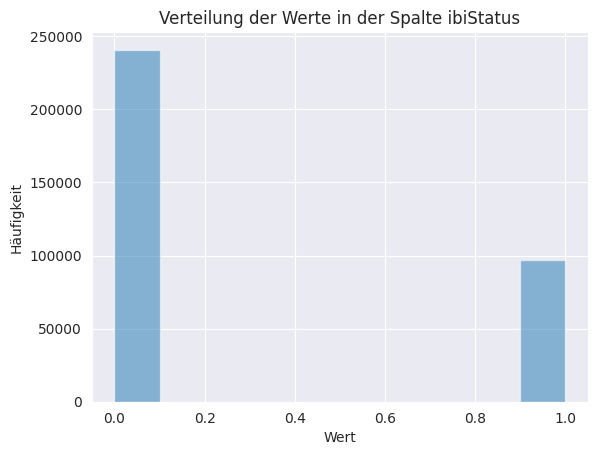

In [14]:
plt.hist(student_data['ibiStatus'].dropna(), bins=10, alpha=0.5)
plt.title('Verteilung der Werte in der Spalte ibiStatus')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.show()

In [15]:
df_complete = student_data.dropna(subset=['hr', 'hrStatus', 'ibiStatus'])

# Trainieren
model = LinearRegression()
model.fit(df_complete[['hr', 'hrStatus']], df_complete['ibiStatus'])

# Vorhersage der fehlenden Werte
student_data.loc[student_data['ibiStatus'].isna(), 'ibiStatus'] = model.predict(student_data[student_data['ibiStatus'].isna()][['hr', 'hrStatus']])


In [16]:
for col in student_data:
  num_missing = student_data[student_data[col].isna() ==True].shape[0]
  print('Anzahl der NAN-Werte pro Spalte {}: {}'.format(col, num_missing))

Anzahl der NAN-Werte pro Spalte sessionId: 0
Anzahl der NAN-Werte pro Spalte timestamp: 0
Anzahl der NAN-Werte pro Spalte x: 338892
Anzahl der NAN-Werte pro Spalte y: 338892
Anzahl der NAN-Werte pro Spalte z: 338892
Anzahl der NAN-Werte pro Spalte ppgValue: 338892
Anzahl der NAN-Werte pro Spalte hr: 0
Anzahl der NAN-Werte pro Spalte hrIbi: 0
Anzahl der NAN-Werte pro Spalte hrStatus: 0
Anzahl der NAN-Werte pro Spalte ibiStatus: 0
Anzahl der NAN-Werte pro Spalte notification: 8824306
Anzahl der NAN-Werte pro Spalte engagement: 8824306
Anzahl der NAN-Werte pro Spalte affect: 8824438
Anzahl der NAN-Werte pro Spalte context: 8824445


In [27]:
# Erstellen Sie eine Maske, die True ist, wo alle vier Spalten NaN sind
mask = student_data[['x', 'y', 'z', 'ppgValue']].isnull().all(axis=1)

# Überprüfen Sie, ob die Anzahl der True-Werte in der Maske der Anzahl der NaNs in einer der Spalten entspricht
if mask.sum() == student_data['x'].isnull().sum():
    print("Die NaN-Werte in den Spalten 'x', 'y', 'z' und 'ppgValue' treten an den gleichen Stellen auf.")
else:
    print("Die NaN-Werte in den Spalten 'x', 'y', 'z' und 'ppgValue' treten nicht an den gleichen Stellen auf.")


Die NaN-Werte in den Spalten 'x', 'y', 'z' und 'ppgValue' treten an den gleichen Stellen auf.


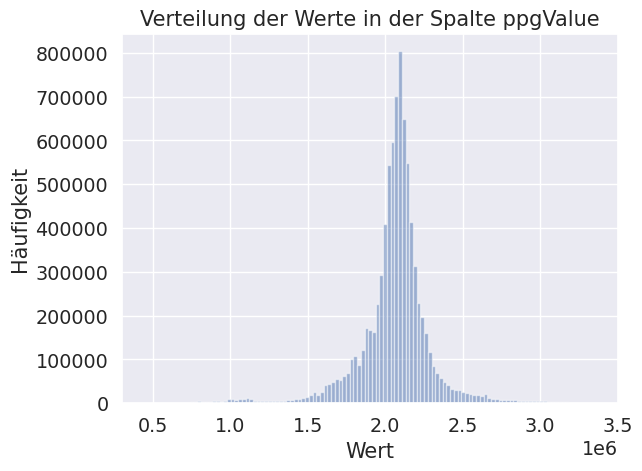

In [62]:
plt.hist(student_data['ppgValue'].dropna(), bins=200, alpha=0.5)
plt.title('Verteilung der Werte in der Spalte ppgValue')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.xlim(300000, 3500000) #4195641.0 -356851.0
plt.show()

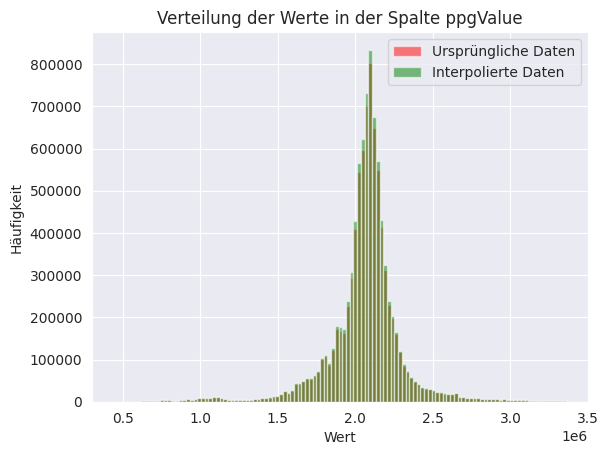

In [9]:
df = student_data.dropna(subset=['ppgValue'])

# Interpolieren
df_interpolated = student_data.interpolate(method='linear')

plt.hist(df['ppgValue'], bins=200, alpha=0.5, color='red', label='Ursprüngliche Daten')
plt.hist(df_interpolated['ppgValue'], bins=200, alpha=0.5, color='green', label='Interpolierte Daten')

plt.title('Verteilung der Werte in der Spalte ppgValue')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.xlim(300000, 3500000)
plt.legend()
plt.show()

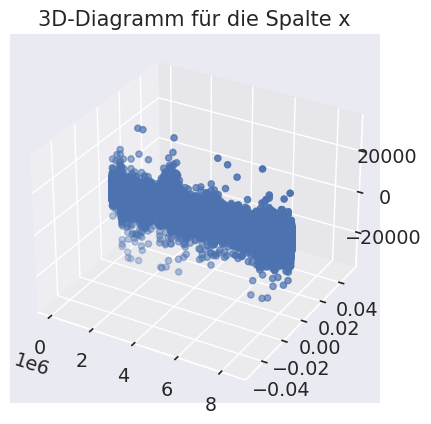

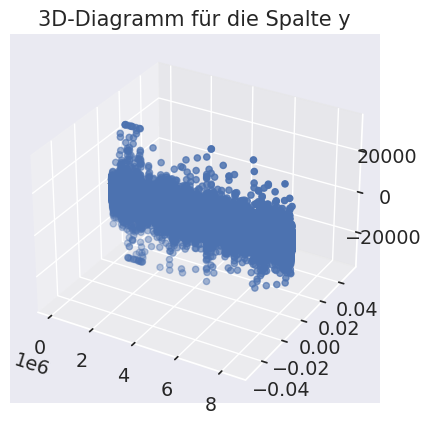

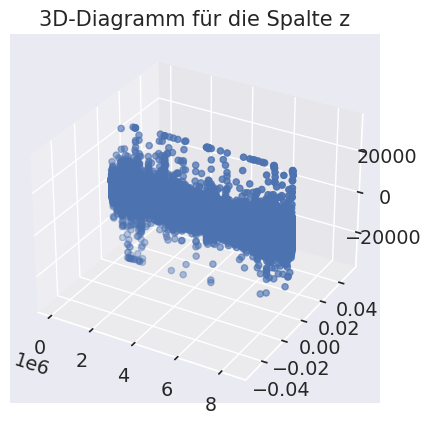

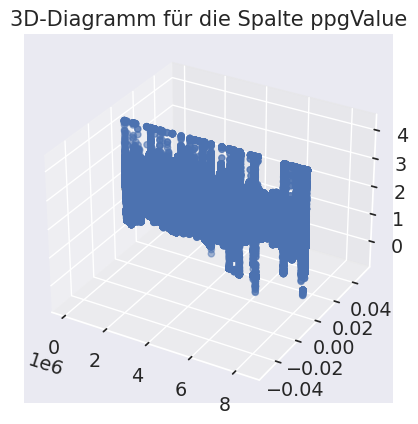

In [70]:
from mpl_toolkits.mplot3d import Axes3D

# Erstellen Sie eine Funktion, um ein 3D-Diagramm für eine bestimmte Spalte zu erstellen
def plot_3d(df, column):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(len(df))
    y = np.zeros(len(df))
    z = df[column]
    ax.scatter(x, y, z)
    ax.set_title('3D-Diagramm für die Spalte {}'.format(column))
    plt.show()

# Entfernen Sie NaN-Werte aus den Daten
df = student_data.dropna(subset=['x', 'y', 'z', 'ppgValue'])

# Erstellen Sie 3D-Diagramme für 'x', 'y', 'z' und 'ppgValue'
for column in ['x', 'y', 'z', 'ppgValue']:
    plot_3d(df, column)



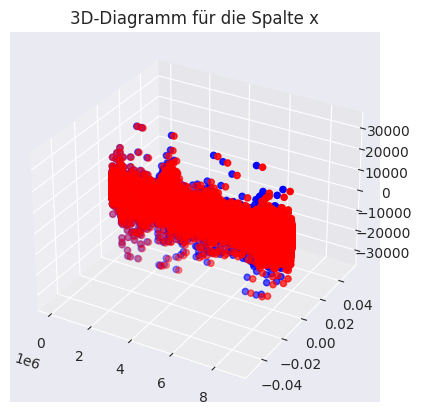

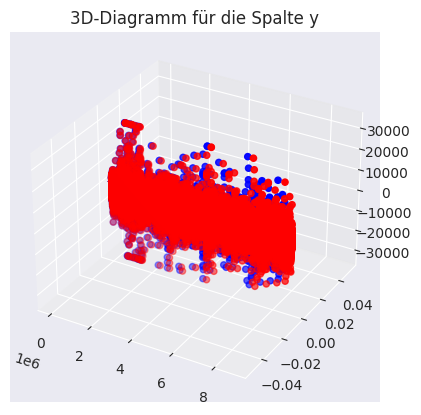

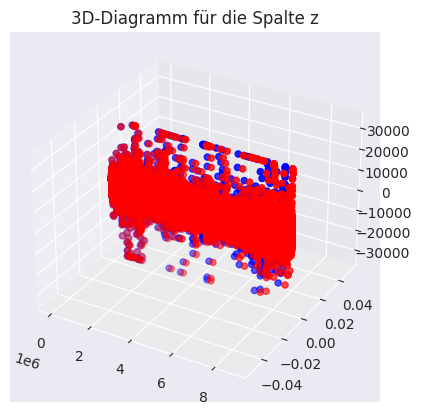

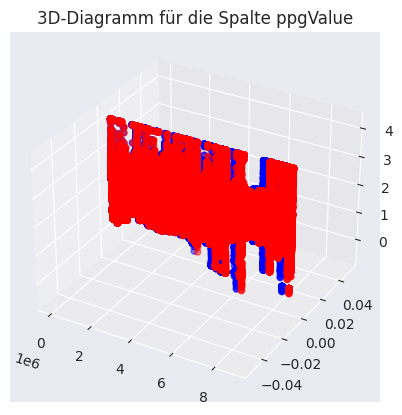

In [3]:
# Erstellen Sie eine Funktion, um ein 3D-Diagramm für eine bestimmte Spalte zu erstellen
def plot_3d(df, df_interpolated, column):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(len(df))
    y = np.zeros(len(df))
    z = df[column]
    ax.scatter(x, y, z, color='blue')  # Originaldaten in Blau

    x_interpolated = np.arange(len(df_interpolated))
    y_interpolated = np.zeros(len(df_interpolated))
    z_interpolated = df_interpolated[column]
    ax.scatter(x_interpolated, y_interpolated, z_interpolated, color='red')  # Interpolierte Daten in Rot

    ax.set_title('3D-Diagramm für die Spalte {}'.format(column))
    plt.show()

# Entfernen Sie NaN-Werte aus den Daten
df = student_data.dropna(subset=['x', 'y', 'z', 'ppgValue'])

# Interpolieren Sie die Daten
df_interpolated = student_data.interpolate(method='linear')

# Erstellen Sie 3D-Diagramme für 'x', 'y', 'z' und 'ppgValue'
for column in ['x', 'y', 'z', 'ppgValue']:
    plot_3d(df, df_interpolated, column)


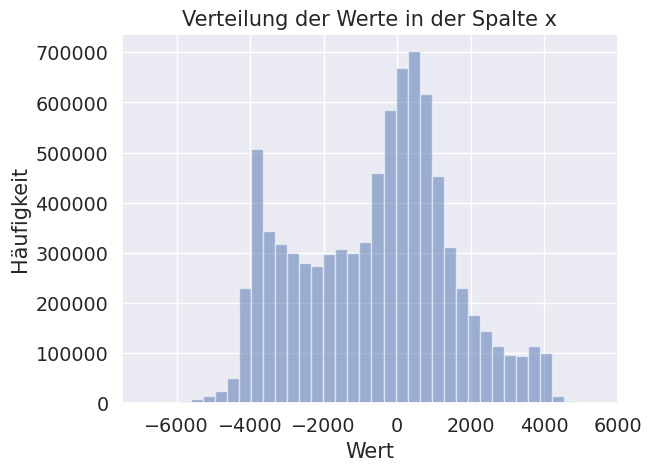

In [40]:
plt.hist(student_data['x'].dropna(), bins=200, alpha=0.5)
plt.title('Verteilung der Werte in der Spalte x')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.xlim(-7500, 6000)
plt.show()

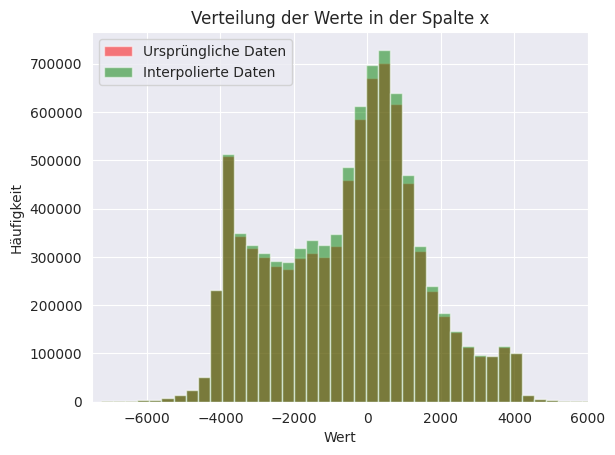

In [6]:
df = student_data.dropna(subset=['x'])

# Interpolieren
df_interpolated = student_data.interpolate(method='linear')

plt.hist(df['x'], bins=200, alpha=0.5, color='red', label='Ursprüngliche Daten')
plt.hist(df_interpolated['x'], bins=200, alpha=0.5, color='green', label='Interpolierte Daten')

plt.title('Verteilung der Werte in der Spalte x')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.xlim(-7500, 6000)
plt.legend()
plt.show()

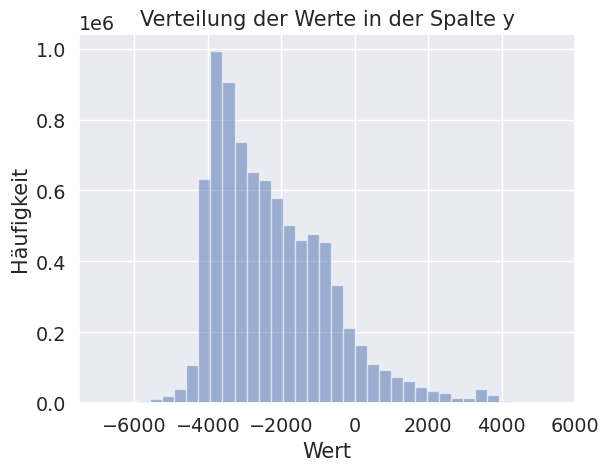

In [39]:
plt.hist(student_data['y'].dropna(), bins=200, alpha=0.5)
plt.title('Verteilung der Werte in der Spalte y')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.xlim(-7500, 6000)
plt.show()

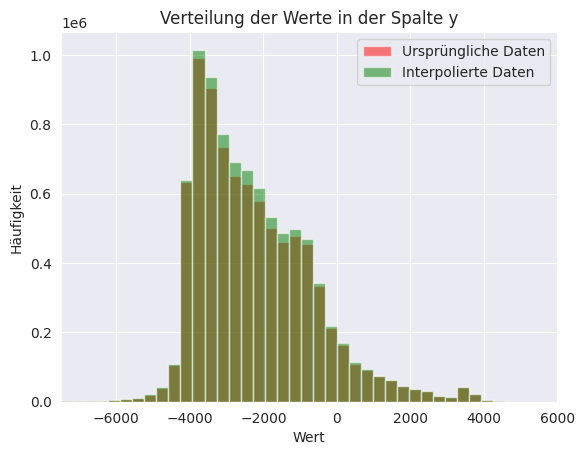

In [7]:
df = student_data.dropna(subset=['y'])

# Interpolieren
df_interpolated = student_data.interpolate(method='linear')

plt.hist(df['y'], bins=200, alpha=0.5, color='red', label='Ursprüngliche Daten')
plt.hist(df_interpolated['y'], bins=200, alpha=0.5, color='green', label='Interpolierte Daten')

plt.title('Verteilung der Werte in der Spalte y')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.xlim(-7500, 6000)
plt.legend()
plt.show()

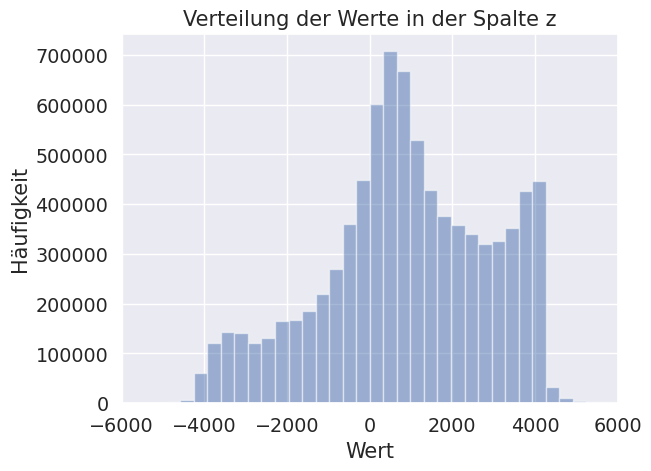

In [67]:
plt.hist(student_data['z'].dropna(), bins=200, alpha=0.5)
plt.title('Verteilung der Werte in der Spalte z')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.xlim(-6000, 6000)
plt.show()

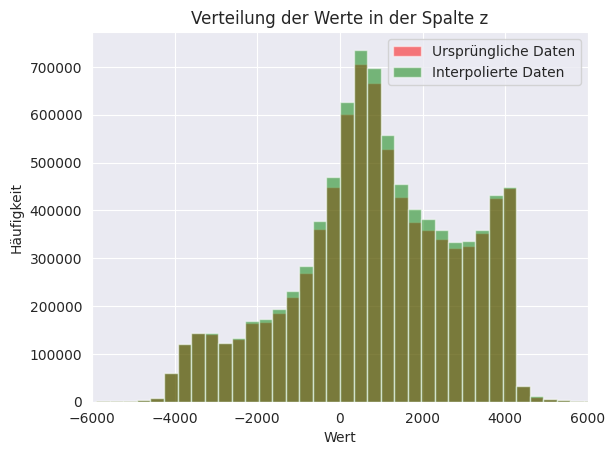

In [8]:
df = student_data.dropna(subset=['z'])

# Interpolieren
df_interpolated = student_data.interpolate(method='linear')

plt.hist(df['z'], bins=200, alpha=0.5, color='red', label='Ursprüngliche Daten')
plt.hist(df_interpolated['z'], bins=200, alpha=0.5, color='green', label='Interpolierte Daten')

plt.title('Verteilung der Werte in der Spalte z')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.xlim(-6000, 6000)
plt.legend()
plt.show()

In [40]:
for col in student_data:
  num_missing = student_data[student_data[col].isna() ==True].shape[0]
  print('Anzahl der NAN-Werte pro Spalte {}: {}'.format(col, num_missing))

Anzahl der NAN-Werte pro Spalte sessionId: 0
Anzahl der NAN-Werte pro Spalte timestamp: 0
Anzahl der NAN-Werte pro Spalte x: 0
Anzahl der NAN-Werte pro Spalte y: 0
Anzahl der NAN-Werte pro Spalte z: 0
Anzahl der NAN-Werte pro Spalte ppgValue: 0
Anzahl der NAN-Werte pro Spalte hr: 0
Anzahl der NAN-Werte pro Spalte hrIbi: 0
Anzahl der NAN-Werte pro Spalte hrStatus: 0
Anzahl der NAN-Werte pro Spalte ibiStatus: 0
Anzahl der NAN-Werte pro Spalte notification: 0
Anzahl der NAN-Werte pro Spalte engagement: 0
Anzahl der NAN-Werte pro Spalte affect: 0
Anzahl der NAN-Werte pro Spalte context: 0


In [17]:
#student_data.to_csv('student_data_notNaN_hrs_ibis.csv', index=False)

In [20]:
# Merge the data based on sessionId and timestamp into a third table
merged_data = pd.merge_asof(student_skeleton.sort_values('timestamp'), student_data.sort_values('timestamp'), on='timestamp', by='sessionId')

# Fill missing values with the next available data from student_data
merged_data = merged_data.fillna(method='bfill')
merged_data

# Save the merged data into a new table
#merged_data.to_csv('daten_für_abgabetraining.csv', index=False)

In [21]:
for col in merged_data:
  num_missing = merged_data[merged_data[col].isna() ==True].shape[0]
  print('Anzahl der NAN-Werte pro Spalte {}: {}'.format(col, num_missing))

Anzahl der NAN-Werte pro Spalte sessionId: 0
Anzahl der NAN-Werte pro Spalte timestamp: 0
Anzahl der NAN-Werte pro Spalte affect_x: 0
Anzahl der NAN-Werte pro Spalte context_x: 0
Anzahl der NAN-Werte pro Spalte x: 0
Anzahl der NAN-Werte pro Spalte y: 0
Anzahl der NAN-Werte pro Spalte z: 0
Anzahl der NAN-Werte pro Spalte ppgValue: 0
Anzahl der NAN-Werte pro Spalte hr: 0
Anzahl der NAN-Werte pro Spalte hrIbi: 0
Anzahl der NAN-Werte pro Spalte hrStatus: 0
Anzahl der NAN-Werte pro Spalte ibiStatus: 0
Anzahl der NAN-Werte pro Spalte notification: 193
Anzahl der NAN-Werte pro Spalte engagement: 193
Anzahl der NAN-Werte pro Spalte affect_y: 193
Anzahl der NAN-Werte pro Spalte context_y: 193


In [22]:
merged_data = merged_data.drop('affect_x', axis=1)
merged_data = merged_data.drop('context_x', axis=1)
merged_data = merged_data.drop('notification', axis=1)
merged_data = merged_data.drop('engagement', axis=1)

In [31]:
merged_data = merged_data.sort_values(by=['sessionId'], ignore_index=True)
merged_data

,sessionId,timestamp,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,affect_y,context_y
0,1,1652042,71.0,1597.0,3929.0,2164173.0,102.807692,668.692308,3.508328,0.422026,NaN,NaN
1,1,1658301,427.0,1555.0,3808.0,2183319.0,95.576923,655.115385,2.593798,0.404457,NaN,NaN
2,1,5914412,622.0,2570.0,3495.0,2225955.0,0.000000,1573.500000,-9.494535,0.172230,NaN,NaN
3,1,5921368,325.0,1577.0,4009.0,2253835.0,76.000000,882.307692,0.117757,0.356890,NaN,NaN
4,2,629724,681.0,1679.0,3694.0,2126935.0,97.000000,1021.384615,2.773785,0.407915,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
188,58,5674479,132.0,-1592.0,3664.0,2047556.0,0.000000,319.923077,-9.494535,0.172230,NaN,NaN
189,58,3179345,-158.0,-1238.0,3829.0,2128642.0,0.000000,320.153846,-9.494535,0.172230,NaN,NaN
190,58,4945652,988.0,-1845.0,3564.0,1964491.0,0.000000,366.923077,-9.494535,0.172230,NaN,NaN
191,58,5688609,180.0,-1992.0,3503.0,2006787.0,0.000000,367.800000,-9.494535,0.172230,NaN,NaN


In [30]:
# Save the merged data into a new table
merged_data.to_csv('daten_für_abgabetraining.csv', index=False)

In [4]:
# Vereinige die beiden Tabellen anhand der Spalten 'sessionId' und 'timestamp'
merged = pd.merge(df1, df2, on=['sessionId', 'timestamp'], how='outer')
merged

,sessionId,timestamp,affect_x,context_x,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect_y,context_y
0,1,8,NaN,NaN,653.0,195.0,4324.0,1917829.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,50,NaN,NaN,659.0,198.0,4096.0,1917495.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,89,NaN,NaN,645.0,149.0,4054.0,1917365.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,128,NaN,NaN,752.0,213.0,4090.0,1918146.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,169,NaN,NaN,652.0,232.0,4088.0,1919319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8824859,58,6661850,NaN,NaN,-825.0,342.0,4044.0,2079382.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8824860,58,6661890,NaN,NaN,-874.0,412.0,4005.0,2079339.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8824861,58,6661931,NaN,NaN,-898.0,839.0,3515.0,2079383.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8824862,58,6661970,NaN,NaN,-753.0,296.0,3871.0,2081733.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
merged_df = pd.merge(df1, df2, on=['sessionId', 'timestamp'], how='inner')

In [6]:
merged_df

,sessionId,timestamp,affect_x,context_x,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,notification,engagement,affect_y,context_y
0,14,3588537,True,False,135.0,1280.0,4001.0,2241713.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20,462024,True,False,817.0,1880.0,3667.0,2156696.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,41,4765589,False,True,341.0,-908.0,3989.0,2504994.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44,3135059,False,True,-1017.0,-139.0,3993.0,2546619.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,51,5641687,False,True,2.0,1784.0,3768.0,2279302.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,57,7634409,True,False,413.0,851.0,3999.0,2256698.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,58,5674479,True,False,132.0,-1592.0,3664.0,2047556.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## T-SNE für Daten, um sie besser nachzuvollziehen.

In [27]:
merged_data_with_g_a = pd.read_csv('merged_preprocessed_data_with_info_numericSamples.csv')

In [28]:
for col in merged_data_with_g_a:
  num_missing = merged_data_with_g_a[merged_data_with_g_a[col].isna() ==True].shape[0]
  print('Anzahl der NAN-Werte pro Spalte {}: {}'.format(col, num_missing))

Anzahl der NAN-Werte pro Spalte sessionId: 0
Anzahl der NAN-Werte pro Spalte timestamp: 0
Anzahl der NAN-Werte pro Spalte x: 0
Anzahl der NAN-Werte pro Spalte y: 0
Anzahl der NAN-Werte pro Spalte z: 0
Anzahl der NAN-Werte pro Spalte ppgValue: 0
Anzahl der NAN-Werte pro Spalte hr: 0
Anzahl der NAN-Werte pro Spalte hrIbi: 0
Anzahl der NAN-Werte pro Spalte hrStatus: 0
Anzahl der NAN-Werte pro Spalte ibiStatus: 0
Anzahl der NAN-Werte pro Spalte notification: 936143
Anzahl der NAN-Werte pro Spalte engagement: 936143
Anzahl der NAN-Werte pro Spalte affect: 0
Anzahl der NAN-Werte pro Spalte context: 0
Anzahl der NAN-Werte pro Spalte timestamp_seconds: 0
Anzahl der NAN-Werte pro Spalte gender: 0
Anzahl der NAN-Werte pro Spalte age: 0


In [29]:
merged_data_with_g_a = merged_data_with_g_a.drop(['notification', 'engagement', 'timestamp' , 'sessionId', 'timestamp_seconds'], axis=1)

In [30]:
merged_data_with_g_a

,x,y,z,ppgValue,hr,hrIbi,hrStatus,ibiStatus,affect,context,gender,age
0,-0.817280,-1.243972,-1.373627,-0.836820,-1.705613,-0.80625,-10.0,1.0,RELAXED,OTHER,0,0
1,-0.462069,-1.265349,-0.968578,-0.836019,-1.705613,-0.80625,-10.0,1.0,RELAXED,OTHER,0,0
2,-0.502114,-1.378423,-0.978265,-0.835742,-1.705613,-0.80625,-10.0,1.0,RELAXED,OTHER,0,0
3,-0.628180,-1.291789,-1.053947,-0.833803,-1.705613,-0.80625,-10.0,1.0,RELAXED,OTHER,0,0
4,-0.643753,-1.511186,-1.270700,-0.822534,-1.705613,-0.80625,-10.0,1.0,RELAXED,OTHER,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
936138,0.162772,1.818190,1.559938,-6.947695,-2.489220,-0.26051,-10.0,0.0,RELAXED,CONVERSATION,0,0
936139,0.144701,1.862090,1.679660,-6.949882,-2.489220,-0.26051,-10.0,0.0,RELAXED,CONVERSATION,0,0
936140,0.072416,1.893158,1.801186,-6.953875,-2.489220,-0.26051,-10.0,0.0,RELAXED,CONVERSATION,0,0
936141,0.187330,1.736469,1.853527,-6.962480,-2.489220,-0.26051,-10.0,0.0,RELAXED,CONVERSATION,0,0


In [35]:
x_data = merged_data_with_g_a.drop(['affect', 'context'], axis=1)
y_data = merged_data_with_g_a.drop(['x', 'y', 'z', 'ppgValue', 'hr', 'hrIbi', 'hrStatus', 'ibiStatus', 'gender', 'age'], axis=1)

In [46]:
y_data

,affect,context
0,RELAXED,OTHER
1,RELAXED,OTHER
2,RELAXED,OTHER
3,RELAXED,OTHER
4,RELAXED,OTHER
...,...,...
936138,RELAXED,CONVERSATION
936139,RELAXED,CONVERSATION
936140,RELAXED,CONVERSATION
936141,RELAXED,CONVERSATION


In [37]:
tsne = TSNE(learning_rate=100, n_components=2)
x_tsne = tsne.fit_transform(x_data) #['ANGRY', 'HAPPY', 'RELAXED', 'SAD']

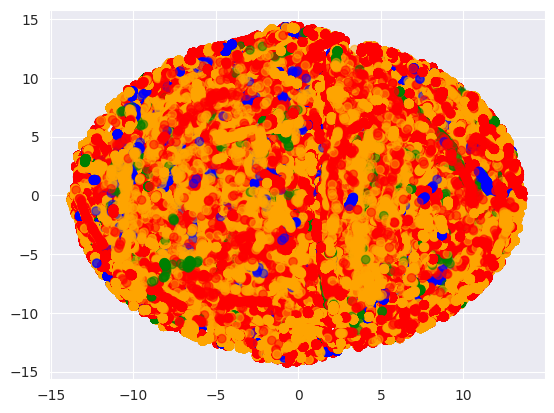

In [47]:
plt.scatter(
    x_tsne[:, 0],
    x_tsne[:, 1],
    c=y_data["affect"].map({'ANGRY': "blue", 'HAPPY': "orange", 'RELAXED': "red", 'SAD': "green"}),
    alpha=0.5,
);

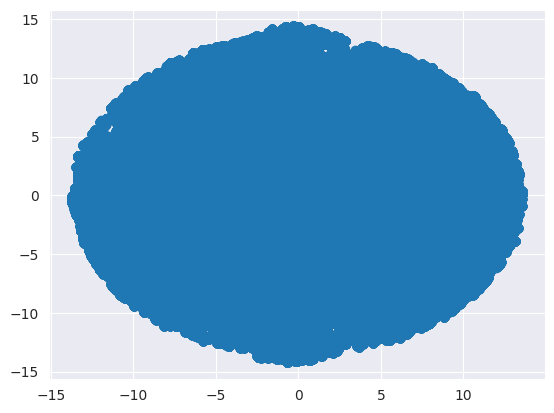

In [42]:
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], alpha=0.5);